# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
from catboost import CatBoostRegressor

import lightgbm as lgb
from lightgbm import LGBMRegressor

from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import time

import warnings
warnings.filterwarnings("ignore")

from IPython.display import display, HTML, Image

In [2]:
df= pd.read_csv('datasets/autos.csv')

### Анализ данных

In [3]:
df.sample(n=5)


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
21108,2016-03-08 14:57:26,1900,coupe,1990,manual,0,scirocco,150000,0,petrol,volkswagen,yes,2016-03-08 00:00:00,0,32479,2016-04-06 03:44:49
273474,2016-03-15 19:56:21,1950,bus,2004,auto,131,other,125000,3,petrol,mazda,no,2016-03-15 00:00:00,0,68239,2016-03-15 19:56:21
218261,2016-03-11 11:56:11,950,sedan,1997,manual,90,megane,125000,11,petrol,renault,no,2016-03-11 00:00:00,0,8393,2016-03-12 16:19:01
87503,2016-04-03 18:38:29,7900,sedan,2006,auto,115,golf,60000,2,petrol,volkswagen,yes,2016-04-03 00:00:00,0,27356,2016-04-03 18:38:29
110486,2016-03-05 19:53:31,6900,sedan,2007,manual,105,beetle,100000,1,gasoline,volkswagen,no,2016-03-05 00:00:00,0,52072,2016-04-07 14:57:43


Часть колонок не несет значимой информации, поэтому создадим список с необходимыми для анализа колонками

In [4]:
used_col = ['Price', 'VehicleType', 'RegistrationYear', 
            'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'NotRepaired']


In [5]:
df[used_col].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
Price               354369 non-null int64
VehicleType         316879 non-null object
RegistrationYear    354369 non-null int64
Gearbox             334536 non-null object
Power               354369 non-null int64
Model               334664 non-null object
Kilometer           354369 non-null int64
FuelType            321474 non-null object
Brand               354369 non-null object
NotRepaired         283215 non-null object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


In [6]:
df[used_col].isna().mean().sort_values(ascending = False).head(6)

NotRepaired    0.200791
VehicleType    0.105794
FuelType       0.092827
Gearbox        0.055967
Model          0.055606
Brand          0.000000
dtype: float64

In [7]:
df[used_col].dropna()['Price'].count()/df['Price'].count()

0.6936667710776055

Имеется достаточно большое количество пропусков. Удалять почти треть данных не хочется. Основные пропуски приходятся на две колонки: наличие ремонт на за время эксплуатации и тип кузова. При этом в целевом признаке пропусков нет.

In [8]:
df[used_col].corr()

,Price,RegistrationYear,Power,Kilometer
Price,1.000000,0.026916,0.158872,-0.333199
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447
Power,0.158872,-0.000828,1.000000,0.024002
Kilometer,-0.333199,-0.053447,0.024002,1.000000


Значимой корреляции между числовыми характеристиками не выявлено, это обеспечивает нахождение более устойчивого решения. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f28e24bfdd0>,
      dtype=object)

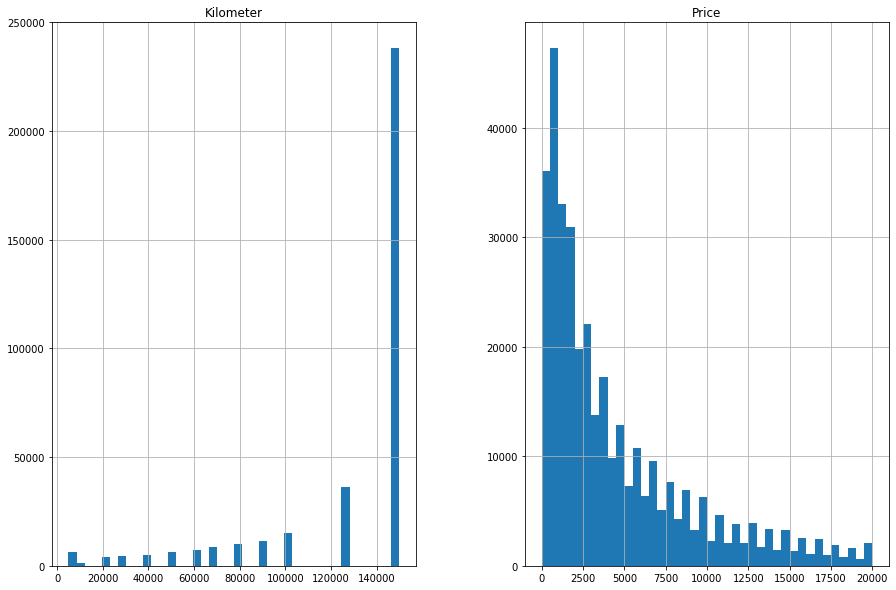

In [9]:
df[['Price','Kilometer']].hist(bins = 40, figsize = (15,10))

Text(0.5, 0, 'Год прозводства')

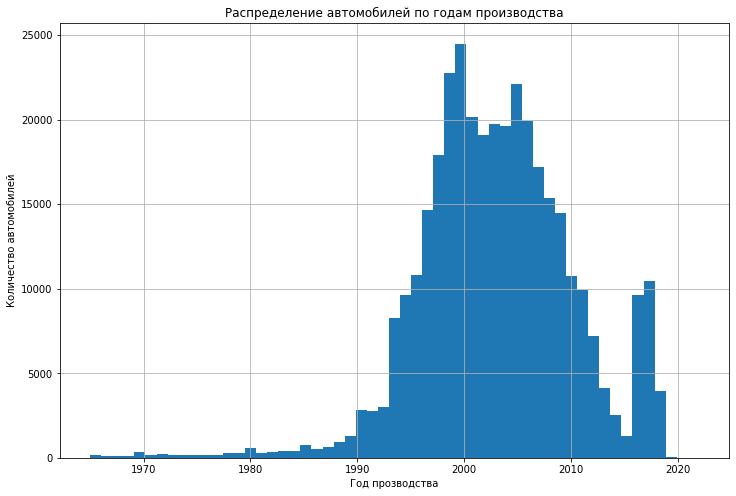

In [10]:
ax=df["RegistrationYear"].plot(kind='hist',range=(1965,2022), bins=55, figsize=(12,8), grid=True,  title='Распределение автомобилей по годам производства')
ax.set_ylabel("Количество автомобилей")
ax.set_xlabel("Год прозводства")

In [11]:
df[used_col].describe()

,Price,RegistrationYear,Power,Kilometer
count,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535
std,4514.158514,90.227958,189.850405,37905.341530
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


- Распределение пробега автомобилей странное, но выбросов нет.
- Распределение мощности автомобилей явно содержит выбросы. 
- Стоимость автомобилей имеет экспоненциальное распределение. Ожидалось логнормальное. Видимо, данные искусственно полученные.
- Год регистрации автомобиля имеет явные ошибки заполнения.

Text(0.5, 0, 'Мощность, л.с.')

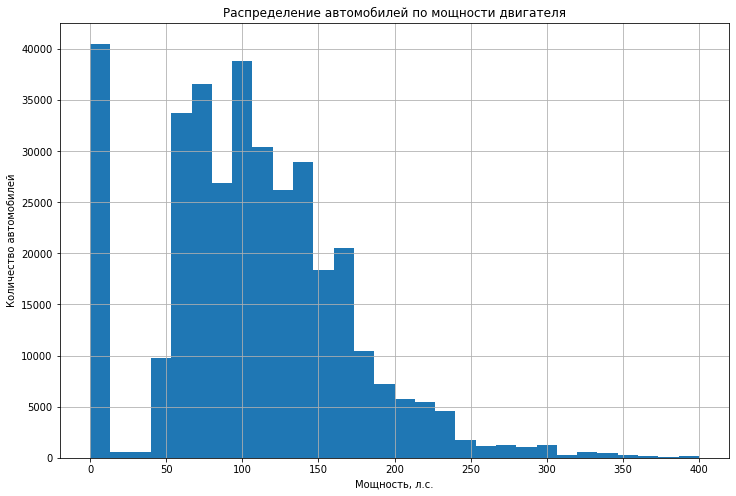

In [12]:
ax=df["Power"].plot(kind='hist',range=(0,400), bins=30, figsize=(12,8), grid=True,  title='Распределение автомобилей по мощности двигателя')
ax.set_ylabel("Количество автомобилей")
ax.set_xlabel("Мощность, л.с.")

Из графика мощности двигателя автомобиля видно, основное распределение лежит на интервале от 40 до 300 л.с., что характерно для типичного автомобиля.

### Предобработка данных

In [13]:
100*df[(df['Power']>40) &(df['Power']<300) ]['Power'].count()/df['Power'].count()

87.10524904830841

Основываясь на здравом смысле, мощность современного автомобили вряд ли меньше 40 л.с. И машины с мощностью свыше 300 л.с. должны рассматриваться либо в категории грузовых, либо в категории элитных спорткаров, поэтому данные машины также выбиваются из общей массы. Ограничение по мощности двигателя обеспечивает сохранение 87.1 % данных, при этом точность предсказаний должна только выиграть. 

In [14]:
df = df[(df['Power']>40) &(df['Power']<300)]

In [15]:
df[(df['RegistrationYear']>1992)&(df['RegistrationYear']<2022)]['Price'].count()/df['Price'].count()

0.9567602065609673

Машины, выпущенные во времена СССР, явно будут отличаться по своим технологическим свойствам, таких машин не так много количеству (меньше 3,5 %). Поэтому предлагается их убрать как выбросы. В случае необходимости оценивания стоимости таких машин, необходимо для них построить отдельную модель.

In [16]:
df = df[(df['RegistrationYear']>1992)&(df['RegistrationYear']<2022)]

Удалим столбцы не имеющие значение. 

In [17]:
df = df.drop(['DateCrawled', 
              'RegistrationMonth', 
              'DateCreated', 
              'NumberOfPictures', 
              'PostalCode', 
              'LastSeen'], axis=1)
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


In [18]:
for col in df.columns:
    if df[col].isnull().sum() > 0:
        df[col].fillna('unknown', inplace=True)
                            

## Обучение моделей

### Подготовка данных для машинного обучения

Преобразуем категориальные признаки с параметром drop_first=True для сокращения количества новых столбцов (дамми-ловушка)

In [19]:
df_ohe = pd.get_dummies(df, drop_first=True)
df_ohe.head()

,Price,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
1,18300,2011,190,125000,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163,125000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,3600,2008,69,90000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,650,1995,102,150000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [20]:
target = df_ohe['Price']
features = df_ohe.drop('Price', axis=1)

In [21]:
features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                              target, 
                                                                              train_size=0.60, 
                                                                              test_size=0.40, 
                                                                              random_state=123)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, 
                                                                            target_valid, 
                                                                            train_size=0.50, 
                                                                            test_size=0.50, 
                                                                            random_state=123)

In [22]:
samples = {'Размер обучающей выборки' : features_train, 
          'Размер валидационной выборки': features_valid, 
          'Размер тестовой выборки': features_test}

for key, value in samples.items():
    print(key + ':', value.shape)

Размер обучающей выборки: (177196, 308)
Размер валидационной выборки: (59065, 308)
Размер тестовой выборки: (59066, 308)


In [23]:
numeric = ['RegistrationYear', 'Power', 'Kilometer']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [24]:
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

### Обучение моделей

#### Линейная регрессия

In [25]:
model_lr = LinearRegression()
start = time.time() 
model_lr.fit(features_train, target_train)
end_time_fit = time.time() - start
print('End time: ', end_time_fit)

End time:  19.267579317092896


In [26]:
start = time.time() 
predictions_lr = model_lr.predict(features_valid)
end_time_predict = time.time() - start

In [27]:
rsme_lr = (mean_squared_error(target_valid, predictions_lr))**0.5

In [28]:
results = []
results.append({'Модель': 'LinearRegression', 
                'Параметры': np.nan, 
                'Время обучения': end_time_fit, 
                'Скорость предсказания': end_time_predict, 
                'RMSE': rsme_lr})

pd.DataFrame(results)

,Модель,Параметры,Время обучения,Скорость предсказания,RMSE
0,LinearRegression,NaN,19.267579,0.189723,2317.661578


#### LGBMRegressor

In [29]:
parameters = {'boosting_type': 'gbdt', 
              'max_depth': 11, 
              'n_estimators': 120, 
              'random_state': 123}

In [30]:
model_lgbm = LGBMRegressor(**parameters)

In [31]:
start = time.time() 
model_lgbm.fit(features_train, target_train)
end_time_fit = time.time() - start
print('End time: ', end_time_fit)

End time:  10.046657800674438


In [32]:
start = time.time() 
predictions_lgbm = model_lgbm.predict(features_valid, verbose=2)
end_time_predict = time.time() - start
print('End time: ', end_time_predict)

End time:  1.1928365230560303


In [33]:
rsme_lgbm  = (mean_squared_error(target_valid, predictions_lgbm))**0.5

In [34]:
results.append({'Модель': 'LGBMRegressor', 
                'Параметры': parameters, 
                'Время обучения': end_time_fit, 
                'Скорость предсказания': end_time_predict, 
                'RMSE': rsme_lgbm})

pd.DataFrame(results)

,Модель,Параметры,Время обучения,Скорость предсказания,RMSE
0,LinearRegression,NaN,19.267579,0.189723,2317.661578
1,LGBMRegressor,"{'boosting_type': 'gbdt', 'max_depth': 11, 'n_...",10.046658,1.192837,1651.295432


#### CatBoostRegressor

In [35]:
for iteration in range(70, 121, 10):
    
    for depth in range(5, 12, 2):
    
        model_cbr = CatBoostRegressor(random_state=123, iterations=iteration, loss_function='RMSE', depth=depth)
    
        start = time.time() 
        model_cbr.fit(features_train, target_train)
        end_time_fit = time.time() - start

        start = time.time() 
        predictions_cbr = model_cbr.predict(features_valid, verbose=1)
        end_time_predict = time.time() - start

        RMSE = (mean_squared_error(target_valid, predictions_cbr))**0.5
    
        results.append({'Модель': 'CatBoostRegressor', 
                        'Параметры': {'random_state':123, 
                                      'iterations': iteration, 
                                      'loss_function': 'RMSE', 
                                      'depth': depth}, 
                        'Время обучения': end_time_fit, 
                        'Скорость предсказания': end_time_predict, 
                        'RMSE': RMSE})

0:	learn: 4455.9019048	total: 91.4ms	remaining: 6.31s
1:	learn: 4372.1230381	total: 195ms	remaining: 6.64s
2:	learn: 4292.4136951	total: 385ms	remaining: 8.59s
3:	learn: 4215.6173472	total: 487ms	remaining: 8.03s
4:	learn: 4141.6699390	total: 592ms	remaining: 7.69s
5:	learn: 4070.2147160	total: 692ms	remaining: 7.38s
6:	learn: 4000.0967871	total: 882ms	remaining: 7.94s
7:	learn: 3928.5125173	total: 982ms	remaining: 7.61s
8:	learn: 3864.9064822	total: 1.08s	remaining: 7.36s
9:	learn: 3800.8141580	total: 1.19s	remaining: 7.12s
10:	learn: 3740.6531598	total: 1.29s	remaining: 6.91s
11:	learn: 3680.9000395	total: 1.48s	remaining: 7.14s
12:	learn: 3622.1221304	total: 1.58s	remaining: 6.93s
13:	learn: 3566.4037694	total: 1.68s	remaining: 6.73s
14:	learn: 3513.3765571	total: 1.79s	remaining: 6.55s
15:	learn: 3462.1834742	total: 1.89s	remaining: 6.38s
16:	learn: 3414.3463620	total: 2.08s	remaining: 6.47s
17:	learn: 3365.8659928	total: 2.18s	remaining: 6.29s
18:	learn: 3320.4093817	total: 2.28s	

In [36]:
pd.DataFrame(results).style.highlight_min(color = 'lightgreen', axis = 0)

,Модель,Параметры,Время обучения,Скорость предсказания,RMSE
0,LinearRegression,nan,19.2676,0.189723,2317.66
1,LGBMRegressor,"{'boosting_type': 'gbdt', 'max_depth': 11, 'n_estimators': 120, 'random_state': 123}",10.0467,1.19284,1651.3
2,CatBoostRegressor,"{'random_state': 123, 'iterations': 70, 'loss_function': 'RMSE', 'depth': 5}",14.6567,0.038691,2247.35
3,CatBoostRegressor,"{'random_state': 123, 'iterations': 70, 'loss_function': 'RMSE', 'depth': 7}",16.4262,0.0138845,2121.83
4,CatBoostRegressor,"{'random_state': 123, 'iterations': 70, 'loss_function': 'RMSE', 'depth': 9}",19.899,0.0178084,2035.7
5,CatBoostRegressor,"{'random_state': 123, 'iterations': 70, 'loss_function': 'RMSE', 'depth': 11}",25.0553,0.0173504,1970.3
6,CatBoostRegressor,"{'random_state': 123, 'iterations': 80, 'loss_function': 'RMSE', 'depth': 5}",16.052,0.0134728,2179.36
7,CatBoostRegressor,"{'random_state': 123, 'iterations': 80, 'loss_function': 'RMSE', 'depth': 7}",18.3476,0.014663,2051.91
8,CatBoostRegressor,"{'random_state': 123, 'iterations': 80, 'loss_function': 'RMSE', 'depth': 9}",21.519,0.016293,1964.91
9,CatBoostRegressor,"{'random_state': 123, 'iterations': 80, 'loss_function': 'RMSE', 'depth': 11}",26.5979,0.0696189,1903.84


Из анализа результатов работы модели можно сделать следующие выводы:
- линейная регрессия не показала лучших результатов:
    - время обучения достаточно большое;
    - скорость предсказания досточно большое;
    - качество предсказания не посредственное;
- модель LGBMRegressor:
    - показала лучшее качество;
    - очень длительное время обучения;
    - длительное время предсказания;
- модель CatBoostRegressor:
    - показала относительно быстро время обучения и предсказания, но невысокое качество предсказания;
- таким образом, можно сделать вывод, что нет "идеальной модели" есть несколько критерием и, исходя из требований, можно подобрать рациональную модель. В тоже время необходимо отметить, что все представленные характеристики обучения являются величинами случайными и могут меняться в зависимости от выборки, гиперпараметров, randon state и других параметров.
 

## Анализ моделей

In [37]:
dummy_regr = DummyRegressor(strategy='mean')

dummy_regr.fit(features_train, target_train)
predictions_r_dummy = dummy_regr.predict(features_test)
print('RMSE dummy:', mean_squared_error(target_test, predictions_r_dummy)**0.5)

RMSE dummy: 4531.148053544476


In [38]:
predictions_lgbm = model_lgbm.predict(features_test, verbose=2)
print('RMSE dummy:', mean_squared_error(target_test, predictions_lgbm)**0.5)    

RMSE dummy: 1680.9377608288266


Сравнение на тестовой выборке для примитивной модели и для модели LGBMRegressor показало, что модель LGBMRegressor показала сопоставимые результаты по сравнению с валидной выборкой и значительно лучшие результаты по сравнению с примитивной моделью.

## Общий вывод

Из анализа результатов работы модели можно сделать следующие выводы:
- линейная регрессия не показала лучших результатов:
    - время обучения достаточно большое;
    - скорость предсказания досточно большое;
    - качество предсказания не посредственное;
- модель LGBMRegressor:
    - показала лучшее качество;
    - очень длительное время обучения;
    - длительное время предсказания;
- модель CatBoostRegressor:
    - показала относительно быстро время обучения и предсказания, но невысокое качество предсказания;
- таким образом, можно сделать вывод, что нет "идеальной модели" есть несколько критерием и, исходя из требований, можно подобрать рациональную модель. В тоже время необходимо отметить, что все представленные характеристики обучения являются величинами случайными и могут меняться в зависимости от выборки, гиперпараметров, randon state и других параметров.
 - cравнение на тестовой выборке для примитивной модели и для модели LGBMRegressor показало, что модель LGBMRegressor показала сопоставимые результаты по сравнению с валидной выборкой и значительно лучшие результаты по сравнению с примитивной моделью.
- для окончательного выбора моделей от заказчика требуются конкретные требования по скорости работы (например, время прогнизирования должно быть не больше 200 мс с вероятностью не менее 0.99 или что-то подобное..) и качествую прогнозирования. 
- также на этапе общения с заказчиком нужно уточнить какие модели он предполагает оценивать, так как весь автопром до 1992 года был отброшен на этапе очистки данных как нерепрезентативный. 
